# 画图：当客户端并不是从预训练参数开始的

In [6]:
xls_str = '''
pre-FT	0	2400	4800	7200	9600	12000	14400
MIA	0.7422	0.7256	0.7283	0.7185	0.7234	0.7418	0.7375
TAG	0.6832	0.6838	0.6891	0.6811	0.698	0.6946	0.6908
SIP	0.7966	0.7978	0.8176	0.7969	0.8049	0.8063	0.8052
BiSR (b)	0.8426	0.8306	0.8542	0.8358	0.8451	0.8505	0.8408
BiSR (b+f)	0.9328	0.9157	0.9137	0.9139	0.9273	0.9326	0.9399
ppl	28.858	27.995	28.475	31.512	32.613	33.642	36.705
'''
rows = xls_str.split('\n')
rows = [row.split('\t') for row in rows if row]
rows = {row[0]: [float(f) for f in row[1:]] for row in rows}
rows['pre-FT']= [int(f) for f in rows['pre-FT']]

In [10]:
rouges = {}
rouges_bi = {}
rouges_bip = {}
rouges_tag = {}
rouges_mia = {}
ppl = {}

for idx,ep in enumerate(rows['pre-FT']):
    rouges[ep] = rows['SIP'][idx]
    rouges_bi[ep] = rows['BiSR (b)'][idx]
    rouges_bip[ep] = rows['BiSR (b+f)'][idx]
    rouges_tag[ep] = rows['TAG'][idx]
    rouges_mia[ep] = rows['MIA'][idx]
    ppl[ep] = rows['ppl'][idx]

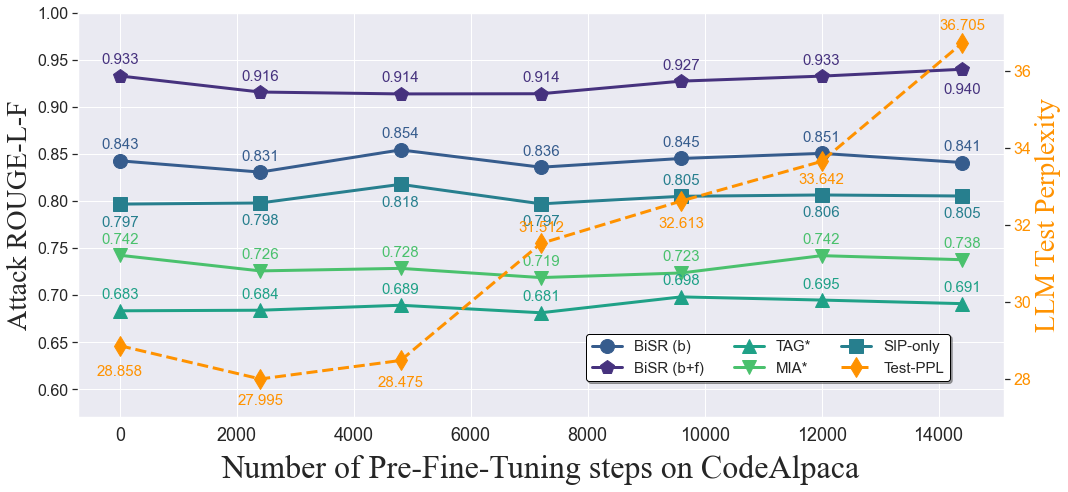

In [55]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style("darkgrid")
fig, ax1 = plt.subplots(figsize=(15, 7))
# plot rouge

atk_colors2 = sns.color_palette('coolwarm', 6)
atk_colors3 = sns.color_palette('cool', 6)
atk_colors4 = sns.color_palette('Spectral', 6)
color_ppl = sns.color_palette("autumn", 6)[3]
all_data = { 'Test-PPL':ppl,'BiSR (b)': rouges_bi, 'SIP-only': rouges, 'TAG*': rouges_tag, 'MIA*': rouges_mia, 'BiSR (b+f)': rouges_bip}
atk_colors = sns.color_palette("viridis", 6)
colors = {'BiSR (b)': atk_colors[1], 'SIP-only': atk_colors[2], 'TAG*': atk_colors[3],
            'MIA*': atk_colors[4], 'BiSR (b+f)': atk_colors[0],'Test-PPL':color_ppl}
markers = {'BiSR (b)': 'o', 'SIP-only': 's', 'TAG*': '^','Test-PPL':'d',
            'MIA*': 'v', 'BiSR (b+f)': 'p'}

ax1.set_ylabel('Attack ROUGE-L-F', fontsize=28,fontname="Times New Roman")
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=16)
# the font suitable for thesis
ax1.set_xlabel('Number of Pre-Fine-Tuning steps on CodeAlpaca', fontsize=32, fontname="Times New Roman", labelpad=10)
ax1.set_ylim(0.57, 1.0)
ax2 = ax1.twinx()
ax2.set_ylabel('LLM Test Perplexity', fontsize=28, fontname="Times New Roman", color=color_ppl)
ax2.tick_params(axis='y', labelcolor=color_ppl, labelsize=16)
ax2.set_ylim(27, 37.5)
for name, data in all_data.items():
    axis = ax1
    linestyle='-'
    if name =='Test-PPL':
        axis = ax2
        linestyle = '--'
    axis.plot(data.keys(), data.values(), color=colors[name], marker=markers[name], markersize=14, label=name, linestyle=linestyle, linewidth=3)

    for i, (ep, rg) in enumerate(data.items()):
        ofst = 12
        if name == 'SIP-only':
            ofst = -22
            if ep == 9600:
                ofst = 12
        if name == 'BiSR (b+f)':
            if ep == 14400:
                ofst = -24
        if name =='Test-PPL':
            ofst = -26
            if ep == 7200:
                ofst = 12
            elif ep == 0:
                ofst = -30
            elif ep == 12000:
                ofst = -22
            elif ep == 14400:
                ofst = 14

        axis.annotate(f'{rg:.3f}', (ep, rg), textcoords="offset points",
                     xytext=(0, ofst),
                     ha='center', fontsize=15, color=colors[name])



handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = [handles[0], handles[4], handles[2], handles[3], handles[1]]
labels = [labels[0], labels[4], labels[2], labels[3], labels[1]]
handles.extend(handles2)
labels.extend(labels2)
plt.legend(handles, labels,  loc='lower right', bbox_to_anchor=(0.95, 0.07), ncol=3, fontsize=15, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',facecolor='white')

# the legend with rounded corner and white background
# fig.legend(loc='lower right', bbox_to_anchor=(0.91, 0.16), ncol=2, fontsize=15, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',facecolor='white')

ax2.yaxis.grid(False)


# save the figure
plt.tight_layout()
plt.savefig('./pre_ft.pdf')